# Imports

In [1]:
from dataset import MyData
from model import Net
from config import device, PATH_TO_TARGET0, PATH_TO_TARGET, PATH_TO_INPUT

from PIL import ImageOps, Image
from ipywidgets import interact
import glob

import torch
import numpy as np
import matplotlib.pyplot as plt

Selected devie is cuda:0


# Loss parameters optimization

## Graphical approach

### Dataset class

In [12]:
class InputImagesInfo(torch.utils.data.Dataset):
    def __init__(self, path_to_inputs, path_to_targets):
        self.info_dict = {'img_list': [],
                            'width_list': [],
                            'height_list': [],
                            'total_pixel_list': [],
                            'bound_length_list': [],
                            'mask_list': [],
                            'bound_mask_list': [],
                            'row_numbers_list': [],}
        for (input_path, target_path) in zip(path_to_inputs, path_to_targets):
            img = np.array(ImageOps.grayscale(Image.open(input_path))).astype(int)
            width, height = img.shape
            
            total_pixel = width * height
            bound_length = len(img.reshape(1, -1) < 255)
            mask = img.reshape(1, -1) == 255
            bound_mask = img.reshape(1, -1) < 255
            row_numbers = 1 * height
            
            img = np.array(ImageOps.grayscale(Image.open(target_path))).astype(int)
            img[img == 90] = -1
            img[img == 190] = 1
            img = torch.from_numpy(img)

            for key in self.info_dict.keys():
                self.info_dict[key].append(locals()[key[:-5]])

    def __len__(self):
        return len(self.info_dict['img_list'])

    def __getitem__(self, idx):
        return [value[idx] for value in self.info_dict.values()]

In [13]:
batch = InputImagesInfo(path_to_inputs=[PATH_TO_INPUT + '0001.png'],
                         path_to_targets=[PATH_TO_TARGET + '0001.png'])

1


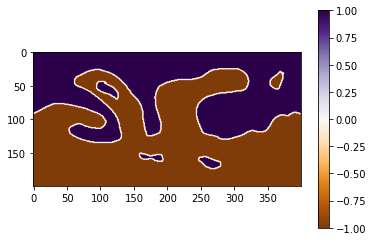

In [14]:
print(len(batch))
plt.imshow(batch[0][0], cmap='PuOr')
plt.colorbar()

### Calculating of the integrals in loss which are not dependent on the weights

In [15]:
loss, f_abs_integral, bound_integral, orientation_integral, f_integral = torch.zeros(5)
integrals_dict = {'f_abs_integral': [],
                    'bound_integral': [],
                    'f_integral': []}

for img, width, height, total_pixel, bound_length, mask, bound_mask, row_numbers in batch:
    img = img.flatten()
    
    f_integral = img.sum().abs() / total_pixel
    f_abs_integral = 1 - img[mask].abs().sum() / (total_pixel - bound_length) # хочу НЕ границу +-1
    bound_integral = img[bound_mask].pow(2).sum() / bound_length # хочу на границе 0

    for key in integrals_dict.keys():
        integrals_dict[key].append(locals()[key])
        

In [16]:
integrals_dict

{'f_abs_integral': [tensor(0.0379)],
 'bound_integral': [tensor(0.)],
 'f_integral': [tensor(0.1589)]}

In [17]:
def compute_loss(weights_list): 
    f_integral_weight, f_abs_integral_weight, bound_integral_weight = weights_list
    # print(f_integral_weight, f_abs_integral_weight, bound_integral_weight)
    # f_abs_integral_weight = 0
    local_vars = locals()
    # print(locals()[key+'_weight'])
    res = sum([sum(local_vars[key+'_weight'] * np.array(integrals_dict[key])) for key in integrals_dict.keys()])
    return res
    # return f_integral_weight*sum(integrals_dict['f_integral']) + f_abs_integral_weight*sum(integrals_dict['f_abs_integral']) + bound_integral_weight*sum(integrals_dict['bound_integral'])

### Tests

#### Interactive

In [18]:
@interact(f_integral_weight=(0, 10, 0.01), f_abs_integral_weight=(0, 10, 0.01), bound_integral_weight=(0, 10, 0.01))
def get_result(f_integral_weight=1., f_abs_integral_weight=1., bound_integral_weight=1.):
    w1, w2, w3 = f_integral_weight, f_abs_integral_weight, bound_integral_weight
    print("loss(f_integral_weight={}, f_abs_integral_weight={}, bound_integral_weight={}) is {}".format(w1, w2, w3, compute_loss([w1,w2,w3])))

interactive(children=(FloatSlider(value=1.0, description='f_integral_weight', max=10.0, step=0.01), FloatSlide…

#### 2D map

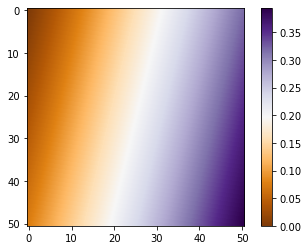

In [19]:
x = y = np.linspace(0, 2, 51)
z = np.array([compute_loss([i, j, 1]) for j in y for i in x])
Z = z.reshape(51, 51)
plt.imshow(Z, interpolation='bilinear', cmap='PuOr')
plt.colorbar()
plt.show()

## Analitycally approach

#### The loss function depends on the integrals $I_i$ and the corresponding weights $w_i$ and is of the form $$\mathcal{L} = \text{Loss}(w_1, \ldots, w_n, I_1, \ldots, I_n) = \sum_1^n w_i \times I_i$$ But $I_i$ does not depend on the weights $w_i$. Therefore, $$\frac{\partial I_i}{\partial w_j} = 0$$ $$\frac{\partial\mathcal{L}}{\partial w_i} = I_i$$ It means that the loss function has no singular points.